## Install packages

In [ ]:
# [1] Set Kaggle Credentials (Replace with your actual username and key)
import os
os.environ['KAGGLE_USERNAME'] = "ashrakattamer"
os.environ['KAGGLE_KEY'] = "2b208f90a5ec718e07dd9a8c01511344" # Your API key

# [3] Download the Hespress Dataset
!kaggle datasets download -d tariqmassaoudi/hespress

Dataset URL: https://www.kaggle.com/datasets/tariqmassaoudi/hespress
License(s): CC0-1.0
  0% 0.00/67.2M [00:00<?, ?B/s]
100% 67.2M/67.2M [00:00<00:00, 1.25GB/s]


In [ ]:
# [2] Install Dependencies and Unzip
%%capture
# This command is often used to suppress the output of the pip install commands
!pip install pyarabic
!pip install pystemmer

# Unzip the downloaded dataset into a new directory
!unzip hespress.zip -d hespressData

## Import Packages

In [ ]:
import os
import torch
import pyarabic.araby as ar
import re
import Stemmer
import functools
import operator
import string
import gc
import random
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from sklearn.utils import resample
import torch.nn as nn

import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [ ]:
# if there is a GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
  print("No GPU available, using the CPU instead.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check all files in dataset
for dirname,_, filename in os.walk('hespressData'):
    for file in filename:
        print(os.path.join(dirname, file))

hespressData/comments_economie.csv
hespressData/stories_medias.csv
hespressData/stories_tamazight.csv
hespressData/comments_marocains-du-monde.csv
hespressData/stories_orbites.csv
hespressData/comments_regions.csv
hespressData/comments_art-et-culture.csv
hespressData/stories_societe.csv
hespressData/comments_orbites.csv
hespressData/comments_politique.csv
hespressData/stories_faits-divers.csv
hespressData/comments_medias.csv
hespressData/stories_sport.csv
hespressData/comments_tamazight.csv
hespressData/stories_economie.csv
hespressData/stories_marocains-du-monde.csv
hespressData/stories_politique.csv
hespressData/comments_societe.csv
hespressData/stories_art-et-culture.csv
hespressData/stories_regions.csv
hespressData/comments_faits-divers.csv
hespressData/comments_sport.csv


In [ ]:
csv_stories=[csv_file for csv_file in glob.glob('hespressData/*.csv') if 'stories' in csv_file]

import pandas as pd

stories_df=pd.DataFrame()
for csv_file in csv_stories:
    df=pd.read_csv(csv_file,index_col=0,encoding='utf-8')
    stories_df=pd.concat([stories_df,df],ignore_index=True)


In [ ]:
stories_df.head()

,id,title,date,author,story,topic
0,ace3509004f311eb9845646e69d991ea,"رصيف الصحافة: نبتة ""الداد"" تقتل طفلين وتصيب 6 ...",الجمعة 02 أكتوبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرائد الخاصة بنهاية الأسبوع ن...,medias
1,add8ad1804f311eb8473646e69d991ea,رصيف الصحافة: حموشي يطلق فرقا أمنية جديدة للتد...,الخميس 01 أكتوبر 2020 - 22:00,هسبريس من الرباط,"قراءة رصيف صحافة الجمعة نستهلها من ""المساء""، ا...",medias
2,af3fde3404f311ebaa6c646e69d991ea,رصيف الصحافة: الحُكم بإعدام أب وزوجته لذبح الا...,الأربعاء 30 شتنبر 2020 - 22:00,هسبريس من الرباط,مطالعة أنباء بعض الجرائد الصادرة يوم الخميس نس...,medias
3,b05a858804f311eb98c3646e69d991ea,"رصيف الصحافة: مختبرات خاصة ترفع ""تعريفة"" الكشف...",الثلاثاء 29 شتنبر 2020 - 22:00,هسبريس من الرباط,"قراءة رصيف صحافة يوم الأربعاء نستهلها من ""المس...",medias
4,b17ac2a404f311eb8dce646e69d991ea,رصيف الصحافة: عيوب تشوب مشروعا ملكيا بميزانية ...,الاثنين 28 شتنبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرائد الخاصة بيوم الثلاثاء من...,medias


In [ ]:
stories_df.value_counts('topic')

,count
topic,
art-et-culture,1000
economie,1000
faits-divers,1000
marocains-du-monde,1000
medias,1000
orbites,1000
politique,1000
regions,1000
societe,1000


## Preparing and cleaning data

In [ ]:
stories_df.isnull().sum()

,0
id,0
title,0
date,0
author,0
story,0
topic,0


In [ ]:
stories_df.drop(columns=stories_df.columns[0:4],axis=1,inplace=True)

topics = {
    "art-et-culture": "Art and Culture",
    "economie": "Economy",
    "faits-divers": "Miscellaneous/Current Events",
    "marocains-du-monde": "Moroccans of the World",
    "medias": "Media",
    "orbites": "Orbits",
    "politique": "Politics",
    "regions": "Regions",
    "societe": "Society",
    "sport": "Sport",
    "tamazight": "Tamazight"
}

stories_df['topic'] = stories_df['topic'].replace(topics)

In [ ]:
stories_df.head()

,story,topic
0,قراءة مواد بعض الجرائد الخاصة بنهاية الأسبوع ن...,Media
1,"قراءة رصيف صحافة الجمعة نستهلها من ""المساء""، ا...",Media
2,مطالعة أنباء بعض الجرائد الصادرة يوم الخميس نس...,Media
3,"قراءة رصيف صحافة يوم الأربعاء نستهلها من ""المس...",Media
4,قراءة مواد بعض الجرائد الخاصة بيوم الثلاثاء من...,Media


In [ ]:
st=Stemmer.Stemmer('arabic')

In [ ]:
import re # Note: 're' is assumed to be imported, as per usage
# NOTE: This function relies on a stemmer object named 'st' being defined elsewhere.

# def clean(text):
#     # Remove URLs (http/https and various forms)
#     text = re.sub(r'^https?://\S+/\S+[/r/n]', '', str(text), flags=re.MULTILINE)
#     text = re.sub(r'^http\S+/\S+[/r/n]', '', str(text), flags=re.MULTILINE)
#     text = re.sub(r'http\S+', "", str(text))
#     text = re.sub(r'https\S+', "", str(text))

#     # Remove various types of whitespaces, numbers, and punctuation
#     text = re.sub(r'(\s\s+)', " ", str(text))
#     text = re.sub(r'(\d+)', "", str(text))
#     text = re.sub(r'^\d+\s+\d+\b\d+\b', " ", str(text))
#     text = re.sub(r'\d+', "", str(text))

#     # Remove specific punctuation and symbols
#     text = text.replace("#", " ")
#     text = text.replace("@", " ")
#     text = text.replace("_", " ")

#     # Normalize repeated characters (e.g., "aaaa" -> "a")
#     text = re.sub(r'(.+)\1{1,}', r'\1', text)

#     # Stemming (Apply stemWord to every word and join with spaces)
#     # NOTE: This requires 'st' (the stemmer object) to be defined.
#     text_stem = " ".join([st.stemWord(i) for i in text.split()])

#     # Append the stemmed text to the original text (creating a token mix)
#     text = text + " " + text_stem

#     # Replace common Arabic/other punctuation and symbols with a space
#     text = text.replace("[", " ")
#     text = text.replace("]", " ")
#     text = text.replace("(", " ")
#     text = text.replace(")", " ")
#     text = text.replace("{", " ")
#     text = text.replace("}", " ")

#     return text

def clean(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[_@#]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    # Limit to first 100 tokens to save memory
    text_stem = " ".join(st.stemWord(w) for w in words[:100])
    return text_stem


In [ ]:
stories_df['story'] = stories_df['story'].apply(lambda x:clean(x))

In [ ]:
topic_ids = {
    "Art and Culture": 0,
    "Economy": 1,
    "Miscellaneous/Current Events": 2,
    "Moroccans of the World": 3,
    "Media": 4,
    "Orbits": 5,
    "Politics": 6,
    "Regions": 7,
    "Society": 8,
    "Sport": 9,
    "Tamazight": 10
}

# Create the 'topic_id' column by mapping values from the 'topic' column
stories_df['topic_id'] = stories_df['topic'].replace(topic_ids).astype(int)

/tmp/ipython-input-2175765284.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stories_df['topic_id'] = stories_df['topic'].replace(topic_ids).astype(int)


In [ ]:
stories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story     11000 non-null  object
 1   topic     11000 non-null  object
 2   topic_id  11000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 257.9+ KB


In [ ]:
stories_df.head()

,story,topic,topic_id
0,"قراء مواد بعض جرايد خاص نها اسبوع استهل من ""ال...",Media,4
1,"قراء رصيف صحاف جمع استهل من ""المساء""، الت ورد ...",Media,4
2,"مطالع انباء بعض جرايد صادر يوم خميس استهل من ""...",Media,4
3,"قراء رصيف صحاف يوم اربعاء استهل من ""المساء""، ا...",Media,4
4,"قراء مواد بعض جرايد خاص يوم ثلاثاء من ""المساء""...",Media,4


## EDA

([<matplotlib.patches.Wedge at 0x7e7fe44c50a0>,
 [Text(1.0554422651544488, 0.30990583235177455, 'Media'),
  Text(0.7203467604911828, 0.8313245723842514, 'Tamazight'),
  Text(0.15654621983618647, 1.088803600772426, 'Orbits'),
  Text(-0.456956526593232, 1.000595189276787, 'Society'),
  Text(-0.9253790575509673, 0.5947046324404104, 'Miscellaneous/Current Events'),
  Text(-1.0999999999999959, -9.616505800409723e-08, 'Sport'),
  Text(-0.9253786699920394, -0.5947052354938238, 'Economy'),
  Text(-0.45695659020408813, -1.000595160226679, 'Moroccans of the World'),
  Text(0.15654654000415874, -1.0888035547392039, 'Politics'),
  Text(0.7203472031493262, -0.8313241888186242, 'Art and Culture'),
  Text(1.0554425040580646, -0.30990501871967563, 'Regions')],
 [Text(0.5756957809933357, 0.16903954491914971, '9.1%'),
  Text(0.3929164148133724, 0.45344976675504617, '9.1%'),
  Text(0.08538884718337443, 0.593892873148596, '9.1%'),
  Text(-0.2492490145053992, 0.5457791941509746, '9.1%'),
  Text(-0.50475221

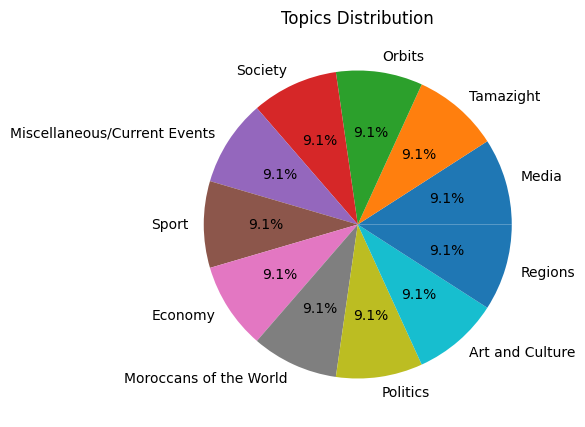

In [ ]:
topics=stories_df.topic.value_counts()
plt.figure(figsize=(10,5))
plt.title('Topics Distribution')
plt.pie(topics,labels=topics.index,autopct='%1.1f%%')

## Loading the Data

In [ ]:
lenghts=stories_df['story'].apply(len)

In [ ]:
max_lenght=lenghts.max()
min_lenght=lenghts.min()
mean_lenght=lenghts.mean()
median_lenght=lenghts.median()
std_lenght=lenghts.std()
print(f'Max Lenght: {max_lenght}\nMin Lenght: {min_lenght}\nMean Lenght: {mean_lenght}\nMedian Lenght: {median_lenght}\nStandard Deviation: {std_lenght}')

Max Lenght: 661
Min Lenght: 110
Mean Lenght: 506.0419090909091
Median Lenght: 511.0
Standard Deviation: 40.83569431697042


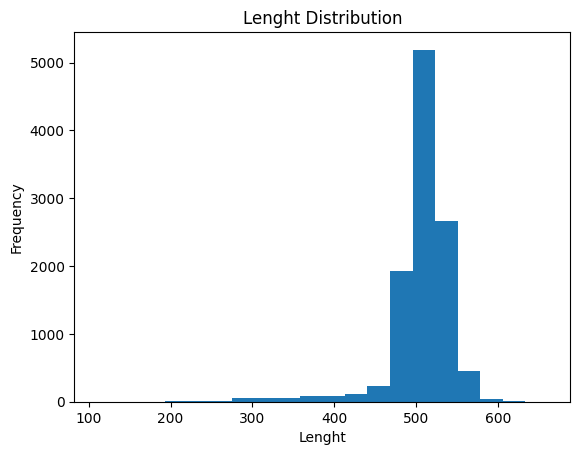

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lenghts,bins=20)
plt.xlabel('Lenght')
plt.ylabel('Frequency')
plt.title('Lenght Distribution')
plt.show()

In [ ]:
max_len=lenghts.quantile(0.75)

print(f'Max Lenght: {int(max_len)}')

Max Lenght: 526


In [ ]:
model_name="asafaya/bert-base-arabic"
max_lenght=128
batch_size=8

In [ ]:
stories_df=stories_df.sample(frac=1).reset_index(drop=True)

In [ ]:
stories_df.reset_index(drop=True,inplace=True)

In [ ]:
stories_df

,story,topic,topic_id
0,اعل معهد مهد بن برك - ذاكر حية، الذ يوجد مقر ف...,Orbits,5
1,تم احباط محاول ھجر سری انطلاق من شریط ساحل تاب...,Miscellaneous/Current Events,2
2,"علم ""هسبورت"" من مصادر مطلع ان ايوب لكحل، لاعب ...",Sport,9
3,يجتاز حوال طالب من جامع قاض عياض، ممن ينتم الي...,Regions,7
4,اعلن عصب وطن لكر قدم احترافية، جمعة، تاجيل ثلا...,Sport,9
...,...,...,...
10995,تناقل سايل اعلام رنس اصداء ما تم اعل عنه، مساء...,Media,4
10996,كشف عثمان فردوس، زير ثقاف والشباب والرياضة، ان...,Media,4
10997,"تتنافس اربع عشر شاب مغرب علي لقب ""ملك جمال اما...",Tamazight,10
10998,بعد تكليف زار الصح موسسا رعا الصح اول (المراكز...,Society,8


In [ ]:
# Assuming 'stories_df' is the final DataFrame containing all processed data

# 1. Training Set (First 7000 rows)
train_texts = stories_df.iloc[:7000]['story'].values
train_labels = stories_df.iloc[:7000]['topic_id'].values

# 2. Validation Set (Rows 7000 up to 9000)
valid_texts = stories_df.iloc[7000:9000]['story'].values
valid_labels = stories_df.iloc[7000:9000]['topic_id'].values

# 3. Test Set (From row 9000 to the end)
test_texts = stories_df.iloc[9000:]['story'].values
test_labels = stories_df.iloc[9000:]['topic_id'].values

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model_name,max_length=max_lenght, truncation=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# conver texts to numbers
train_encodings=tokenizer(list(train_texts),truncation=True,padding='max_length',max_length=max_lenght)
valid_encodings=tokenizer(list(valid_texts),truncation=True,padding='max_length',max_length=max_lenght)
test_encodings=tokenizer(list(test_texts),truncation=True,padding='max_length',max_length=max_lenght)

In [ ]:
class StoriesDataset(Dataset):
    def __init__(self,encodings,labels):
        self.encodings=encodings
        self.labels=labels
    def __getitem__(self,idx):
        item={key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
        # Ensure correct data types for tensors
        item['input_ids'] = torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long)
        item['attention_mask'] = torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long)
        item['token_type_ids'] = torch.tensor(self.encodings['token_type_ids'][idx], dtype=torch.long)
        item['labels']=torch.tensor(self.labels[idx], dtype=torch.long)
        return item # Added return statement
    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset=StoriesDataset(train_encodings,train_labels)
valid_dataset=StoriesDataset(valid_encodings,valid_labels)
test_dataset=StoriesDataset(test_encodings,test_labels)

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
for batch in train_loader:
    print(batch)
    break



{'input_ids': tensor([[    2, 20748,  2873,  ...,  1015,  9728,     3],
        [    2, 18005, 11200,  ..., 25327,  4777,     3],
        [    2, 28128, 13911,  ...,  1760, 10655,     3],
        ...,
        [    2, 30256, 14797,  ...,  3311,  1963,     3],
        [    2,  2097,  1045,  ..., 17863,  1012,     3],
        [    2,  4508,  1992,  ...,  4524,  1852,     3]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([5, 0, 8, 9, 2, 4, 9, 6])}


## Building BERTMODEL For Topic Classification

In [ ]:
model=BertForSequenceClassification.from_pretrained(model_name,num_labels=11)

model.train()
optim=torch.optim.Adam(model.parameters(),lr=5e-5)
NUM_EPOCHS=10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# def compute_accuracy(model,data_loader,device):
#     with torch.no_grad():
#         correct_pred,num_examples=0,0
#         for batch_idx,batch in enumerate(data_loader):
#           input_ids=batch['input_ids'].to(device)
#           attention_mask=batch['attention_mask'].to(device)
#           labels=batch['labels'].to(device)
#           # forward pass
#           outputs=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
#           logits=outputs['logits']
#           # get predicted labels
#           predicted_labels=torch.argmax(logits,1)
#           num_examples+=labels.size(0)
#           correct_pred+=(predicted_labels==labels).sum().item()
#           num_examples+=labels.size(0)

#         return correct_pred.float()/num_examples*100
#         return accuracy

def compute_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            del input_ids, attention_mask, labels, outputs, logits
            torch.cuda.empty_cache()

    return 100 * correct / total


In [ ]:
import torch
from tqdm import tqdm

train_losses = []
train_accuracies = []
valid_accuracies = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Move the model to the device

scaler = torch.cuda.amp.GradScaler()  # Mixed precision training

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch")

    for batch in train_progress:
        # Explicitly cast tensors to long before moving to device
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        labels = batch["labels"].to(device, dtype=torch.long)

        optim.zero_grad()

        # ✅ Use mixed precision for less memory
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        epoch_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())

        # ✅ Free memory of local tensors
        del input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # ===================================
    # EVALUATION PHASE
    # ===================================
    model.eval()
    with torch.no_grad():
        train_accuracy = compute_accuracy(model, train_loader, device)
        valid_accuracy = compute_accuracy(model, valid_loader, device)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Valid Acc: {valid_accuracy:.2f}%")

    # ✅ Clear cache each epoch
    torch.cuda.empty_cache()

/tmp/ipython-input-790037045.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
Epoch 1/10:   0%|          | 0/875 [00:00<?, ?batch/s]/tmp/ipython-input-790037045.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 875/875 [01:28<00:00,  9.91batch/s, loss=0.973]



Epoch 1/10 | Train Acc: 83.87% | Valid Acc: 78.85%


Epoch 2/10: 100%|██████████| 875/875 [01:27<00:00, 10.01batch/s, loss=0.226]



Epoch 2/10 | Train Acc: 93.01% | Valid Acc: 84.50%


Epoch 3/10: 100%|██████████| 875/875 [01:27<00:00,  9.99batch/s, loss=0.767]



Epoch 3/10 | Train Acc: 94.00% | Valid Acc: 81.95%


Epoch 4/10: 100%|██████████| 875/875 [01:27<00:00, 10.02batch/s, loss=0.0253]



Epoch 4/10 | Train Acc: 96.21% | Valid Acc: 81.00%


Epoch 5/10: 100%|██████████| 875/875 [01:27<00:00, 10.01batch/s, loss=0.361]



Epoch 5/10 | Train Acc: 98.17% | Valid Acc: 82.55%


Epoch 6/10: 100%|██████████| 875/875 [01:27<00:00, 10.02batch/s, loss=0.0334]



Epoch 6/10 | Train Acc: 97.87% | Valid Acc: 82.20%


Epoch 7/10: 100%|██████████| 875/875 [01:26<00:00, 10.07batch/s, loss=0.0449]



Epoch 7/10 | Train Acc: 97.06% | Valid Acc: 80.40%


Epoch 8/10: 100%|██████████| 875/875 [01:27<00:00,  9.99batch/s, loss=0.00682]



Epoch 8/10 | Train Acc: 99.24% | Valid Acc: 81.60%


Epoch 9/10: 100%|██████████| 875/875 [01:27<00:00, 10.04batch/s, loss=0.105]



Epoch 9/10 | Train Acc: 98.16% | Valid Acc: 80.25%


Epoch 10/10: 100%|██████████| 875/875 [01:26<00:00, 10.08batch/s, loss=0.161]



Epoch 10/10 | Train Acc: 94.00% | Valid Acc: 78.15%


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

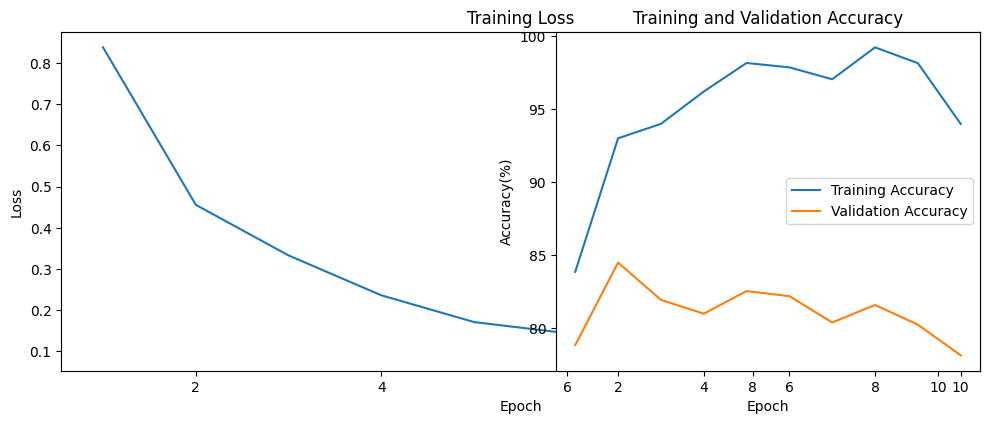

In [ ]:
# plotting loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1,NUM_EPOCHS+1),train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

#Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1,NUM_EPOCHS+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1,NUM_EPOCHS+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Save and load the model

In [ ]:
# save the model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
#load the model
loaded_model=BertForSequenceClassification.from_pretrained(model_name,num_labels=11)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Testing Model

In [ ]:
loaded_model.eval()
loaded_model.to(device) # Use the device variable
print(f"Test accuracy: {compute_accuracy(loaded_model,test_loader,device):.2f}%") # Use the device variable

Test accuracy: 76.30%


# Task
Evaluate the loaded model on custom data.

In [ ]:
import pandas as pd


## Load custom data

### Subtask:
Load your custom data into a pandas DataFrame. Ensure it has a column for the text and a column for the topic labels, similar to the original data.


**Reasoning**:
Create a dummy DataFrame with 'story' and 'topic' columns since the custom data file was not found in previous attempts.



In [ ]:
# Create a larger dummy DataFrame with 'story' and 'topic' columns
data = {'story': [
    "تناول وزير الاقتصاد والمالية اليوم خطة الحكومة الجديدة لتعزيز النمو الاقتصادي في البلاد.",
    "فاز المنتخب الوطني لكرة القدم بمباراة ودية هامة استعدادا للتصفيات القادمة.",
    "افتتح معرض الفن التشكيلي أبوابه للجمهور اليوم في قاعة المدينة الكبرى.",
    "شهدت منطقة الأطلس الكبير تساقطات ثلجية كثيفة خلال عطلة نهاية الأسبوع.",
    "أعلنت وزارة الصحة عن تسجيل حالات إصابة جديدة بفيروس كورونا في عدة مدن.",
    "ناقش البرلمان اليوم مشروع قانون جديد يتعلق بتنظيم الإعلام والصحافة.",
    "انطلقت فعاليات المهرجان الدولي للفيلم في دورته السنوية بمشاركة فنانين عالميين.",
    "توقعات الأرصاد الجوية تشير إلى استمرار الأجواء الباردة في معظم مناطق المملكة.",
    "نظمت جمعية المجتمع المدني حملة نظافة واسعة في الأحياء السكنية.",
    "أسعار النفط تعرف ارتفاعا ملحوظا في الأسواق العالمية خلال الأيام الماضية.",
    "وقع حادث سير مروع على الطريق السيار الرابط بين مدينتين كبيرتين.",
    "احتفلت الجالية المغربية في الخارج بالذكرى السادسة والأربعين للمسيرة الخضراء.",
    "قناة تلفزيونية جديدة تنطلق قريبا مع باقة متنوعة من البرامج الإخبارية والثقافية.",
    "ندوة علمية تناقش آخر التطورات في مجال الطاقة المتجددة في جامعة محمد الخامس.",
    "فرق الإنقاذ تواصل البحث عن شخص مفقود في جبال الريف.",
    "أقيمت مباراة خيرية في كرة السلة لدعم الأسر المعوزة في المدينة.",
    "تنظم وزارة الثقافة ورشات فنية للأطفال خلال العطلة الربيعية.",
    "عرفت أسواق الجملة ارتفاعا في أسعار بعض المواد الأساسية.",
    "تم إلقاء القبض على عصابة إجرامية متخصصة في سرقة السيارات الفارهة.",
    "أصدرت وزارة الداخلية بلاغا بخصوص الإجراءات الجديدة المتعلقة بالحالة الصحية.",
    "تغطية إعلامية خاصة لزيارة الوفد الأجنبي الرفيع المستوى إلى المغرب.",
    "مؤتمر دولي حول التغيرات المناخية ينعقد في مراكش الأسبوع القادم.",
    "حملة تبرع بالدم تعرف إقبالا كبيرا من طرف المواطنين في مختلف المدن.",
    "البورصة المغربية تسجل ارتفاعا في قيمة الأسهم للشركات الكبرى.",
    "نجحت عناصر الشرطة في تفكيك شبكة للاتجار بالمخدرات الصلبة.",
    "احتفالية كبرى بمناسبة رأس السنة الأمازيغية في الأقاليم الجنوبية.",
    "مسابقة ثقافية وفنية تنظمها جمعية فاعلة في مجال الفنون التشكيلية.",
    "تقرير جديد يرصد التحديات التي تواجه قطاع السياحة في المغرب.",
    "تفاصيل جديدة حول جريمة قتل بشعة هزت الرأي العام المحلي.",
    "اتحاد الكرة يعلن عن قائمة اللاعبين المدعوين للمنتخب المحلي.",
    "عرض مسرحي جديد يقدم على خشبة المسرح الوطني محمد الخامس.",
    "توقعات بوصول أمطار الخير إلى المناطق الفلاحية خلال الأيام القادمة.",
    "ورشة عمل حول التنمية المستدامة تنظم بمشاركة خبراء دوليين.",
    "أسعار الخضر والفواكه تعرف استقرارا نسبيا في الأسواق المحلية.",
    "إحباط محاولة تهريب كمية كبيرة من السجائر المهربة.",
    "ندوة صحفية لوزير التربية الوطنية حول مستجدات الدخول المدرسي.",
    "برنامج تلفزيوني جديد يسلط الضوء على قصص نجاح شباب مغربي.",
    "معرض للكتب ينظم في المكتبة الوطنية بالرباط.",
    "عملية أمنية مكثفة تسفر عن اعتقال عدد من المبحوث عنهم.",
    "عقد اجتماع هام بين ممثلي الحكومة والمركزيات النقابية.",
],
        'topic': [
            "Economy", "Sport", "Art and Culture", "Regions", "Society",
            "Politics", "Art and Culture", "Regions", "Society", "Economy",
            "Miscellaneous/Current Events", "Moroccans of the World", "Media", "Orbits", "Regions",
            "Sport", "Art and Culture", "Economy", "Miscellaneous/Current Events", "Politics",
            "Media", "Orbits", "Society", "Economy", "Miscellaneous/Current Events",
            "Tamazight", "Art and Culture", "Economy", "Miscellaneous/Current Events", "Sport",
            "Art and Culture", "Regions", "Society", "Economy", "Miscellaneous/Current Events",
            "Politics", "Media", "Art and Culture", "Miscellaneous/Current Events", "Politics"
        ]}
custom_df = pd.DataFrame(data)
print("Larger dummy custom data created.")
print("Columns in the custom DataFrame:", custom_df.columns.tolist())
display(custom_df.head())

Larger dummy custom data created.
Columns in the custom DataFrame: ['story', 'topic']


,story,topic
0,تناول وزير الاقتصاد والمالية اليوم خطة الحكومة...,Economy
1,فاز المنتخب الوطني لكرة القدم بمباراة ودية هام...,Sport
2,افتتح معرض الفن التشكيلي أبوابه للجمهور اليوم ...,Art and Culture
3,شهدت منطقة الأطلس الكبير تساقطات ثلجية كثيفة خ...,Regions
4,أعلنت وزارة الصحة عن تسجيل حالات إصابة جديدة ب...,Society


## Preprocess custom data

### Subtask:
Apply the same cleaning function (`clean`) and topic mapping (`topic_ids`) to your custom data as was done for the training data.


**Reasoning**:
Apply the cleaning function and topic mapping to the custom data.



In [ ]:
custom_df['story'] = custom_df['story'].apply(lambda x: clean(x))
custom_df['topic_id'] = custom_df['topic'].replace(topic_ids).astype(int)
display(custom_df.head())

/tmp/ipython-input-3001929215.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  custom_df['topic_id'] = custom_df['topic'].replace(topic_ids).astype(int)


,story,topic,topic_id
0,تناول زير اقتصاد والمال يوم خطة حكوم جديد لتعز...,Economy,1
1,فاز منتخب وطن لكر قدم مبارا ود هام استعداد تصف...,Sport,9
2,افتتح معرض الفن تشكيل ابواب جمهور يوم في قاع م...,Art and Culture,0
3,شهد منطق اطلس كبير تساقطا ثلج كثيف خلال عطل نه...,Regions,7
4,اعلن زار الصح عن تسجيل حالا اصاب جديد فيروس كو...,Society,8


## Tokenize custom data

### Subtask:
Use the same tokenizer (`tokenizer`) to tokenize your custom data.


**Reasoning**:
Tokenize the 'story' column of the custom_df DataFrame using the previously defined tokenizer.



In [ ]:
custom_encodings = tokenizer(list(custom_df['story'].values), truncation=True, padding='max_length', max_length=max_lenght)

**Reasoning**:
Evaluate the loaded model on the custom data using the compute_accuracy function and print the result.

In [ ]:
custom_accuracy = compute_accuracy(loaded_model, custom_loader, device)
print(f"Custom data accuracy: {custom_accuracy:.2f}%")

Custom data accuracy: 75.00%
